# Project Week 4 | TEAM 3
---



## Setup PySpark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [3]:
import findspark
import matplotlib.pyplot as plt
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
spark.version

'3.0.0'

# Data Exploration
- USE SPARK / SPARK SQL methods for the following sub-tasks, if possible. 
- Read-in the data and gather statistical information about the data, such as summary statistics, attribute distributions, correlation between attributes, outliers, information about missing data etc.  
- Present and discuss your findings in the report (at least 3 things) and use appropriate visualization if possible. 
- Preprocess the data (imputation, sub-sampling, etc.). Describe in the report in detail what you 
did.  
- Use at least two imputation methods. Analyze and compare the results.

## Read Data

Use this code if `train.csv` and `test.csv` are in your Google Drive. Otherwise import both files into Google Colab and ignore this line.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!cp drive/My\ Drive/test.csv test.csv
!cp drive/My\ Drive/train.csv train.csv

First the given data-csv files need to be imported into the current Google Colab runtime.

In [7]:
# schema = "id INT, gender STRING, age INT, hypertension BOOLEAN, heart_disease STRING, ever_married STRING, work_type STRING, Residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING"
test_df = spark.read.csv("test.csv", 
                         # schema = schema,
                         inferSchema = True, 
                         header = True)
train_df = spark.read.csv("train.csv", 
                          # schema = schema +", stroke BOOLEAN",
                          inferSchema = True,
                          header = True)
train_df.printSchema()
test_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)



Input the tables to SPARK SQL

In [8]:
train_df.createOrReplaceTempView("train_tab")

test_df.createOrReplaceTempView("test_tab")

In [9]:
n_train = train_df.count()
print("There are", n_train, "samples in the training data.")

n_test = test_df.count()
print("There are", n_test, "samples in the test data.")

There are 43400 samples in the training data.
There are 18601 samples in the test data.


## Imputation


First, the missing values of the data are analysed. 

In [10]:
# train_df.apply(lambda x: sum(x.isnull()))
from pyspark.sql.functions import isnull, when, count, col
train_df.select([count(when(isnull(c), c)).alias(c) for c in train_df.columns]).toPandas()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0,0,0,0,0,0,0,0,1462,13292,0


There are missing values in `bmi` and `smoking_status`.

Use [`fillna()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.fillna.html#pyspark.sql.DataFrame.fillna) to fill in missing values.

**Imputation Method 1**: impute with mean of data in `bmi` (bmi is normal distributed normally)

Other option: impute with global mean ([WHO](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/mean-bmi-(kg-m-)-(crude-estimate))) or here [Meta-Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5735219/), [Meta-Study 2](https://globalizationandhealth.biomedcentral.com/articles/10.1186/s12992-019-0457-y), would be 24

In [11]:
train_df = train_df.fillna({'bmi':train_df.groupBy().mean('bmi').head()[0]})
train_df.select([count(when(isnull(c), c)).alias(c) for c in train_df.columns]).toPandas()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0,0,0,0,0,0,0,0,0,13292,0


**Imputation Method 2**: impute with value from randomly selected record

In [12]:
spark.sql("SELECT smoking_status, COUNT(*) AS n FROM train_tab GROUP BY smoking_status;").toPandas()

,smoking_status,n
0,None,13292
1,smokes,6562
2,never smoked,16053
3,formerly smoked,7493


In [13]:
random_ss = train_df.sample(fraction=1.0/n_train, seed = 1243124).first()['smoking_status']
print("NAs in smoking_status are replaced with random variable:", random_ss)

NAs in smoking_status are replaced with random variable: never smoked


In [14]:
train_df = train_df.fillna({'smoking_status': 'never smoked'})
train_df.select([count(when(isnull(c), c)).alias(c) for c in train_df.columns]).toPandas()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0,0,0,0,0,0,0,0,0,0,0


As you can see, all NA values are imputed/gone.

## Analyze Data

This code uses `.toPandas()` to print tables better.

View Head of Data to get a general overview and examples for all attributes.

In [15]:
pandas_df = train_df.toPandas()
pandas_df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,never smoked,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,never smoked,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,never smoked,0


The data is summarised 

In [16]:
train_df.drop('id').describe().toPandas()

,summary,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,count,43400,43400,43400,43400,43400,43400,43400,43400,43400,43400,43400
1,mean,None,42.21789400921646,0.09357142857142857,0.04751152073732719,None,None,None,104.48274999999916,28.605038390005145,None,0.01804147465437788
2,stddev,None,22.519648680503554,0.291234906309397,0.21273274050209726,None,None,None,43.1117509512961,7.638023372051845,None,0.13310292280179215
3,min,Female,0.08,0,0,No,Govt_job,Rural,55.0,10.1,formerly smoked,0
4,max,Other,82.0,1,1,Yes,children,Urban,291.05,97.6,smokes,1


### Histograms
First, we create a histogram to view the distribution of each attribute. 

We can use PySpark for all numerical attributes with the [`histogram()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.histogram.html) function.

0.08 82.0 0 82
10.1 97.6 1 88
55.0 291.05 2 237


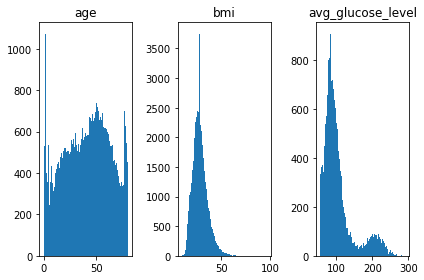

In [18]:
import pandas as pd
import numpy as np

fig, axs = plt.subplots(ncols=3, sharey=False, sharex=False)
# print(train_df.agg({'age':"max", 'age':'min'}).toPandas())

for idx, col in enumerate(['age', 'bmi', 'avg_glucose_level']):#train_df.columns):
  # print(train_df.agg({col:"max", col:"min"}).collect())
  mini, maxi = train_df.agg({col:"min"}).collect()[0]['min('+col+')'], train_df.agg({col:"max"}).collect()[0]['max('+col+')']
  buckets = np.arange(start=mini,
                      stop=maxi,
                      step=1).tolist()
  # Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api
  bins, count = train_df.select(col).rdd.flatMap(lambda x: x).histogram(buckets)
  print(mini, maxi, idx, len(buckets))
  # Loading the Computed Histogram into a Pandas Dataframe for plotting
  axs[idx].bar(x=bins[:-1], height=count, width=1)
  axs[idx].set_title(col)
fig.tight_layout()

For all categroical features we need to can't use `histogram()`, because the function can only be applied to numerical data. Instead, the counts can be implemented using `spark.sql()`.

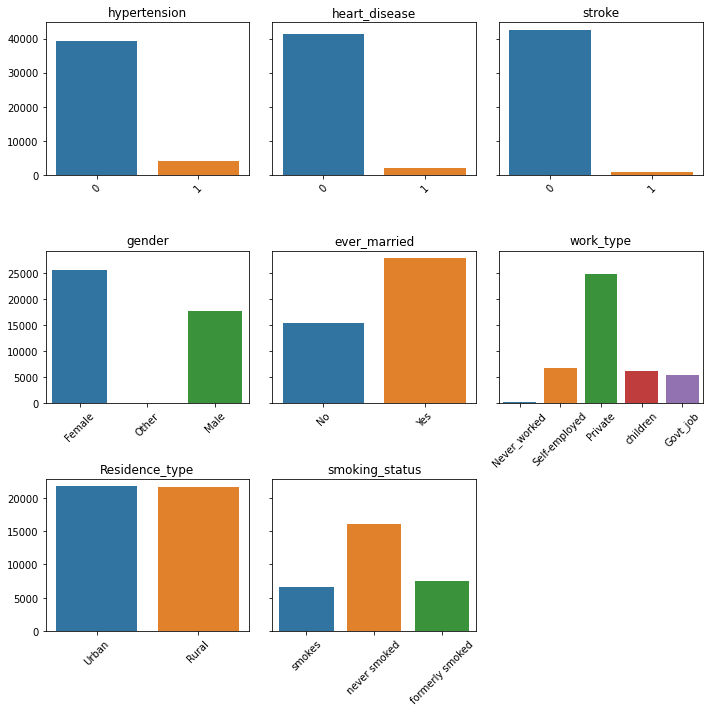

In [19]:
import seaborn as sns
categories = ['hypertension', 'heart_disease', 'stroke', 'gender','ever_married', 'work_type', 'Residence_type', 'smoking_status']
fig, axs = plt.subplots(3,3, figsize=(10,10), sharey='row')

for idx, cat in enumerate(categories):
   counts = spark.sql("SELECT "+cat+", COUNT(*) AS n FROM train_tab GROUP BY "+cat+";").toPandas()
   sns.barplot(data=counts, x=cat, y="n", ax = axs[idx//3, idx%3])
  #  axs[idx//3, idx%3].set_title(cat)
   axs[idx//3, idx%3].tick_params(axis='x', labelrotation=45)
   axs[idx//3, idx%3].set(xlabel=None, ylabel=None, title=cat)
axs[-1,-1].axis('off')
fig.tight_layout()

Another approach is using pandas and seaborn to create a grid with all histograms at once.

In [20]:
categories = ['hypertension', 'heart_disease', 'stroke']#, 'gender','ever_married', 'work_type', 'Residence_type', 'smoking_status']
pandas_df[categories] = pandas_df[categories].apply(lambda col: col.astype(str))
pandas_df.dtypes

id                     int32
gender                object
age                  float64
hypertension          object
heart_disease         object
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                object
dtype: object

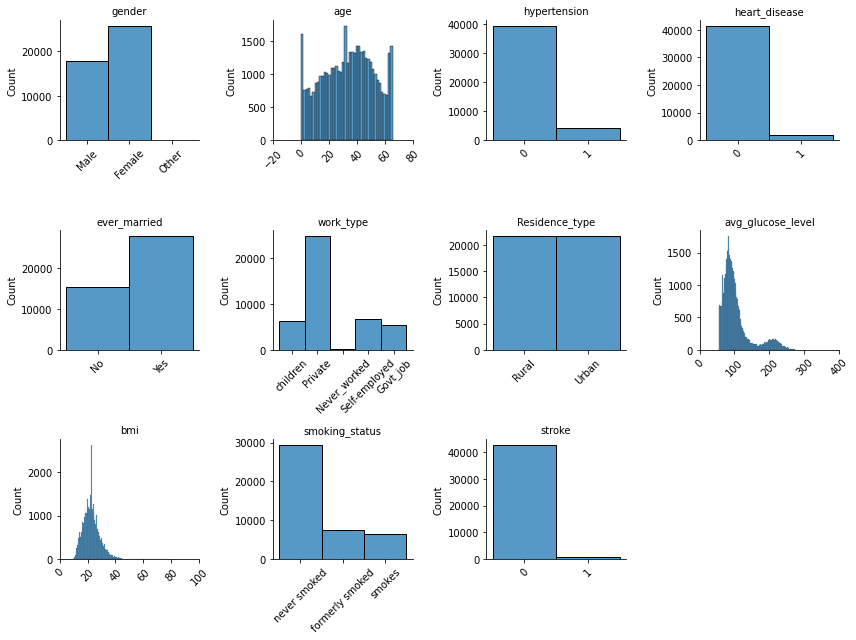

In [21]:
hists = sns.FacetGrid(pandas_df.melt(id_vars='id', var_name='column'), 
                      col='column', col_wrap=4, sharex=False, sharey=False)
hists.map(sns.histplot, 'value')
hists.set_titles(col_template="{col_name}")
hists.set_xticklabels(rotation=45)
hists.set(xlabel=None)
hists.tight_layout()

### Boxplots
Visualization for numerical data: Boxplots

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


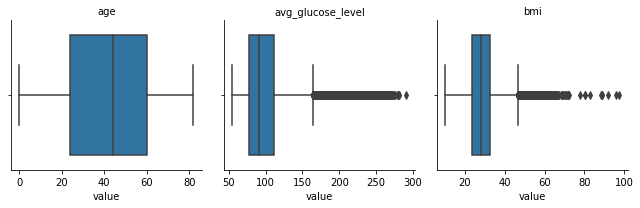

In [22]:
train_df_numeric = train_df.select(['age', 'avg_glucose_level', 'bmi'])
boxes = sns.FacetGrid(data=train_df_numeric.toPandas().melt(var_name='column'),
                      col='column', sharex=False)
boxes.map(sns.boxplot, 'value')
boxes.set_titles(col_template="{col_name}")
boxes.tight_layout()

### Correlation between all numerical attributes

In [23]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=train_df_numeric.columns, outputCol=vector_col)
df_vector = assembler.transform(train_df_numeric).select(vector_col)

# get correlation matrix
corr_matrix = Correlation.corr(df_vector, vector_col, method='pearson').collect()[0][0].values

Text(0.5, 1.0, 'Correlation of numeric Attributes')

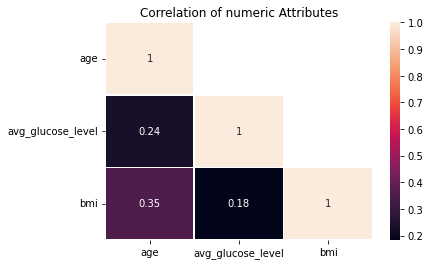

In [24]:
corr_matrix.shape = (3,3)
corr_matrix = np.tril(corr_matrix)
sns.heatmap(corr_matrix, annot=True, 
            xticklabels=['age', 'avg_glucose_level', 'bmi'], yticklabels=['age', 'avg_glucose_level', 'bmi'],
            mask=(corr_matrix==0),
            linewidths=0.5)
plt.yticks(rotation=0)
plt.title("Correlation of numeric Attributes")

### Testing Data
Now let's analyse the testing data.

In [25]:
test_df.describe().toPandas()

,summary,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,count,18601,18601,18601,18601,18601,18601,18601,18601,18601,18010,12850
1,mean,36747.36804472878,None,42.056504489006024,0.09316703403042847,0.048061932154185256,None,None,None,104.3863593355191,28.545324819544625,None
2,stddev,21053.151123778684,None,22.528017622414048,0.29067418204733125,0.21390288127048365,None,None,None,42.606714400087824,7.757091805747331,None
3,min,2,Female,0.08,0,0,No,Govt_job,Rural,55.0,10.2,formerly smoked
4,max,72942,Other,82.0,1,1,Yes,children,Urban,275.72,88.3,smokes


## Subsampling
Create a balanced data set and an unbalanced data set

In [26]:
unbalanced_train = train_df

In [27]:
unbalanced_train.groupBy('stroke').count().toPandas()

,stroke,count
0,1,783
1,0,42617


In [28]:
stroke_count = unbalanced_train.groupBy('stroke').count().first()['count']
not_stroke_count = unbalanced_train.groupBy('stroke').count().tail(1)[0]['count']
ratio = int(not_stroke_count/stroke_count)
print("Percentage of strokes in complete data set", stroke_count/n_train * 100,
      "\nPercentage of not strokes in complete data set", not_stroke_count/n_train * 100,
      "\nRatio (not_stroke/stroke):", ratio)

Percentage of strokes in complete data set 1.804147465437788 
Percentage of not strokes in complete data set 98.1958525345622 
Ratio (not_stroke/stroke): 54


### Undersampling
Ca. 1.8% (783) samples of the original dataset are strokes. 

In [29]:
undersampled_train = train_df.sampleBy('stroke', fractions={0:(stroke_count)/(n_train-stroke_count), 1: 1}, seed=42)
undersampled_train.groupBy('stroke').count().toPandas()

,stroke,count
0,1,783
1,0,824


### Oversampling

Help from [medium](https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253)

In [30]:
from pyspark.sql.functions import col, explode, array, lit
a = range(ratio)
# duplicate the minority rows
oversampled_train = train_df.filter('stroke == 1').withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# oversampled_df.show()
# combine both oversampled minority rows and previous majority rows 
oversampled_train = train_df.filter('stroke == 0').union(oversampled_train)

# train_df.sampleBy('stroke', fractions={0: 0.9, 1:200 }, seed=42)
oversampled_train.groupBy('stroke').count().toPandas()

,stroke,count
0,1,42282
1,0,42617


## Creating a pipeline for the models 
Define categorical Data (use code from [here](https://www.kaggle.com/njalan/healthcare-dataset-stroke-data-pyspark))
and a pipeline to use for the models

In [31]:
# indexing all categorical columns in the dataset
from pyspark.ml.feature import StringIndexer
indexer1 = StringIndexer(inputCol="gender", outputCol="genderIndex")
indexer2 = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
indexer3 = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
indexer4 = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
indexer5 = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")

In [32]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=["genderIndex","ever_marriedIndex","work_typeIndex","Residence_typeIndex","smoking_statusIndex"],
                        outputCols=["genderVec","ever_marriedVec","work_typeVec","Residence_typeVec","smoking_statusVec"])

Use this pipeline to later apply the models!

In [33]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5])
indexed = pipeline.fit(train_df).transform(train_df)

# **Predictor 1 : Decision tree classifier** 

In [34]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')

In [35]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='stroke',featuresCol='features')

In [36]:
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, dtc])

In [37]:
model1= pipeline.fit(unbalanced_train)
model2= pipeline.fit(undersampled_train)
model3= pipeline.fit(oversampled_train)

Making predictions with the model

In [38]:
dtc_predictions1 = model1.transform(unbalanced_train)
dtc_predictions2 = model2.transform(undersampled_train)
dtc_predictions3 = model3.transform(oversampled_train)

In [39]:
dtc_predictions1.select("prediction","probability", "stroke", "features").show(5)
dtc_predictions2.select("prediction","probability", "stroke", "features").show(5)
dtc_predictions3.select("prediction","probability", "stroke", "features").show(5)

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.99201255956151...|     0|(15,[1,2,8,11,12,...|
|       0.0|[0.99201255956151...|     0|[0.0,1.0,58.0,1.0...|
|       0.0|[0.99201255956151...|     0|(15,[0,2,6,10,11,...|
|       0.0|[0.93911126187245...|     0|(15,[0,2,5,6,11,1...|
|       0.0|[0.99201255956151...|     0|(15,[1,2,11,12,13...|
+----------+--------------------+------+--------------------+
only showing top 5 rows

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.97398843930635...|     0|(14,[0,1,5,9,10,1...|
|       1.0|[0.12068965517241...|     1|(14,[1,3,4,5,9,10...|
|       1.0|[0.24691358024691...|     1|(14,[0,1,4,6,10,1...|
|       0.0|[0.97398843930635...|     0|(14,[

In [40]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [41]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")

In [42]:
dtc_acc1 = acc_evaluator.evaluate(dtc_predictions1)
dtc_acc2 = acc_evaluator.evaluate(dtc_predictions2)
dtc_acc3 = acc_evaluator.evaluate(dtc_predictions3)

In [43]:
print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc1*100))
print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc2*100))
print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc3*100))

A Decision Tree algorithm had an accuracy of: 98.20%
A Decision Tree algorithm had an accuracy of: 79.53%
A Decision Tree algorithm had an accuracy of: 78.93%


# **Predictor 2  Logistic Regression**

Importing packages to run our model

In [44]:
from pyspark.ml import Pipeline
# from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

Define LinearRegression algorithm

In [45]:
lr = LogisticRegression(labelCol='stroke',featuresCol='features')

In [46]:
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, lr])

Fitting the model 

In [47]:
model4 = pipeline.fit(unbalanced_train)
model5 = pipeline.fit(undersampled_train)
model6 = pipeline.fit(oversampled_train)

Making the predictions

In [48]:
predictions4 = model4.transform(unbalanced_train)
predictions5 = model5.transform(undersampled_train)
predictions6 = model6.transform(oversampled_train)

Example row to display

In [49]:
predictions4.select("prediction", "probability", "stroke", "features").show(5)
predictions5.select("prediction", "probability", "stroke", "features").show(5)
predictions6.select("prediction", "probability", "stroke", "features").show(5)

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.99977189129433...|     0|(15,[1,2,8,11,12,...|
|       0.0|[0.98049371372286...|     0|[0.0,1.0,58.0,1.0...|
|       0.0|[0.99943453784875...|     0|(15,[0,2,6,10,11,...|
|       0.0|[0.97054944361764...|     0|(15,[0,2,5,6,11,1...|
|       0.0|[0.99999395767818...|     0|(15,[1,2,11,12,13...|
+----------+--------------------+------+--------------------+
only showing top 5 rows

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.95150779333612...|     0|(14,[0,1,5,9,10,1...|
|       1.0|[0.18882439337650...|     1|(14,[1,3,4,5,9,10...|
|       1.0|[0.41203534344333...|     1|(14,[0,1,4,6,10,1...|
|       0.0|[0.95948845517566...|     0|(14,[

# Evaluation of both models

In [50]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol ="stroke",
                                predictionCol="prediction",
                                metricName="rmse")

In [51]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [52]:
lr_acc1 = MulticlassMetrics(predictions4.select('prediction', col('stroke').alias('label').cast("double")).rdd)
lr_acc2 = MulticlassMetrics(predictions5.select('prediction', col('stroke').alias('label').cast("double")).rdd)
lr_acc3 = MulticlassMetrics(predictions6.select('prediction', col('stroke').alias('label').cast("double")).rdd)

In [53]:
print('A logistic regression algorithm had an accuracy of: {0:2.2%}'.format(lr_acc1.accuracy))
print('A logistic regression algorithm had an accuracy of: {0:2.2%}'.format(lr_acc2.accuracy))
print('A logistic regression algorithm had an accuracy of: {0:2.2%}'.format(lr_acc3.accuracy))

A logistic regression algorithm had an accuracy of: 98.20%
A logistic regression algorithm had an accuracy of: 77.16%
A logistic regression algorithm had an accuracy of: 78.08%


Create Latex-Table for Accuracy, F-Measure, Precision, Recall

Model&Dataset & Accuracy & F-Measure & Precision & Recall\\
\midrule Logistic Regression
&unbalanced & 98.20% & 0.00% & 0.00% & 0.00%\\
&undersampled & 77.16% & 77.30% & 74.94% & 79.82%\\
&oversampled & 78.08% & 78.89% & 75.79% & 82.25%\\
\midrule Decision Tree Classifier
&unbalanced & 98.20% & 0.51% & 100.00% & 0.26%\\
&undersampled & 79.53% & 79.78% & 76.90% & 82.89%\\
&oversampled & 78.93% & 79.52% & 77.08% & 82.12%\\


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


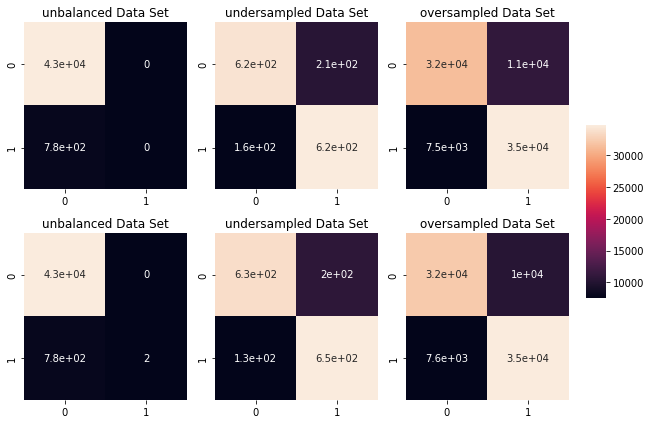

In [54]:
fig,axs = plt.subplots(nrows=2,ncols=3, figsize=(9,6))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

conf_matr_list = []

print("Model&{ds} & {acc} & {fm} & {pr} & {re}\\\\".format(ds="Dataset", acc="Accuracy", fm="F-Measure", pr="Precision", re="Recall"))
model="Logistic Regression"
for idx, (data_set, prediction) in enumerate([('unbalanced', predictions4), ('undersampled', predictions5), ('oversampled', predictions6),
                                              ('unbalanced', dtc_predictions1), ('undersampled', dtc_predictions2),('oversampled',dtc_predictions3)]):
  metrics = MulticlassMetrics(prediction.select('prediction', col('stroke').alias('label').cast("double")).rdd)
  if idx%3==0:
    print("\\midrule", model)
    model="Decision Tree Classifier"
  print("&{ds} & {acc:2.2%} & {fm:2.2%} & {pr:2.2%} & {re:2.2%}\\\\".format(
      ds=data_set, acc=metrics.accuracy, fm=metrics.fMeasure(1.0), pr=metrics.precision(1.0), re=metrics.recall(1.0)
  ))
  conf_matr_list+=[["Decision Tree Classifier" if idx//3 > 0 else "Logistic Regression", 
                    data_set,metrics.confusionMatrix().toArray()]] #x,y, value] for (x,y), value in np.ndenumerate(metrics.confusionMatrix().toArray())]
  sns.heatmap(data=metrics.confusionMatrix().toArray(), 
              ax=axs[idx//3,idx%3], annot=True,
              cbar_ax=cbar_ax).set_title(data_set + " Data Set")
fig.tight_layout(rect=[0, 0, .9, 1])